In [4]:
import numpy as np
import matplotlib.pyplot as plt

# Input is an array. 
input_array = np.array([1,2,3])
exp_array = np.exp(input_array)

print("Input to exp:", input_array)
print("Output of exp:", exp_array)

# Input is a single number
input_val = 1  
exp_val = np.exp(input_val)

print("Input to exp:", input_val)
print("Output of exp:", exp_val)


Input to exp: [1 2 3]
Output of exp: [ 2.71828183  7.3890561  20.08553692]
Input to exp: 1
Output of exp: 2.718281828459045


In [144]:
def sigmoid(z):
    g = 1/(1+np.exp(-z))
    return g

z_tmp = np.linspace(-10,11, 1000)

# Use the function implemented above to get the sigmoid values
y = sigmoid(z_tmp)

# Code for pretty printing the two arrays next to each other
print(np.c_[z_tmp, y])

[[-1.00000000e+01  4.53978687e-05]
 [-9.97897898e+00  4.63622345e-05]
 [-9.95795796e+00  4.73470849e-05]
 ...
 [ 1.09579580e+01  9.99982581e-01]
 [ 1.09789790e+01  9.99982944e-01]
 [ 1.10000000e+01  9.99983299e-01]]


Text(0.5, 0, 'z')

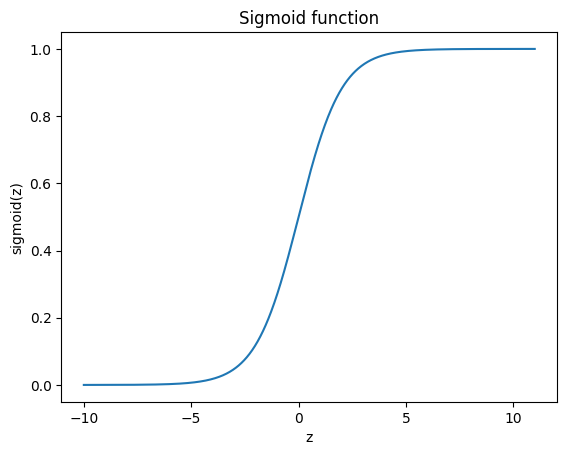

In [145]:
fig,ax = plt.subplots(1,1)
ax.plot(z_tmp, y)

ax.set_title("Sigmoid function")
ax.set_ylabel('sigmoid(z)')
ax.set_xlabel('z')

In [188]:
# Create dataset
import numpy as np
N = 100
dimensions = 2

def create_data_sample():
    # Bias and random value for each dimension
    return np.array( [1.0] + [np.random.uniform(-1, 1) for i in range(dimensions)])

def create_ground_truth_function(dims, weights_amplitude, offset_ratio=0.25):
    weights = np.array([np.random.uniform(-weights_amplitude * offset_ratio, weights_amplitude * offset_ratio)] +
                       [np.random.uniform(-weights_amplitude, weights_amplitude) for i in range(dims)])
    ground_truth_func = lambda x: sigmoid(weights @ x.T)
    label_generator = lambda x:  np.array([np.random.uniform() for i in range(x.shape[0])]) <= ground_truth_func(x) # *2.-1)

    return weights, ground_truth_func, label_generator

true_weights, true_func, label_generator = create_ground_truth_function(dimensions, weights_amplitude=10)

def generate_dataset(N, sample_generator, label_generator):
    X = np.array([sample_generator() for x in range(N)])
    y = label_generator(X)

    return X, y

X, y = generate_dataset(N, create_data_sample, label_generator)


from sklearn.preprocessing import PolynomialFeatures

poly = PolynomialFeatures(degree=2)
X = poly.fit_transform(X[:,1:])


def create_polynomial_labels(X, weights_amplitude, offset_ratio):
    weights = np.array([0, 0, 0, 0, 1, 1]) # np.array([np.random.uniform(-weights_amplitude, weights_amplitude) for i in range(X.shape[1])])
    ground_truths = []
    labels = []
    for x in X:
        ground_truth = sigmoid(weights @ x.T)
        #print(ground_truth)
        label = np.random.uniform() <= ground_truth # *2.-1)
        labels.append(label)
        ground_truths.append(ground_truth)

    return weights, ground_truths, labels

true_weights, true_labels, labels = create_polynomial_labels(X, 10, 0.25)
print(labels)



[False, False, False, True, True, True, False, True, True, False, True, True, True, False, True, False, True, False, False, False, True, False, True, False, False, True, False, True, True, True, False, False, True, False, False, True, True, True, False, True, False, False, False, False, False, True, True, True, True, True, True, False, False, True, True, False, True, False, False, False, False, False, True, True, True, False, True, True, True, True, False, False, True, True, False, True, True, False, True, False, True, True, False, False, True, False, False, False, False, True, False, True, False, False, True, False, True, True, False, True]


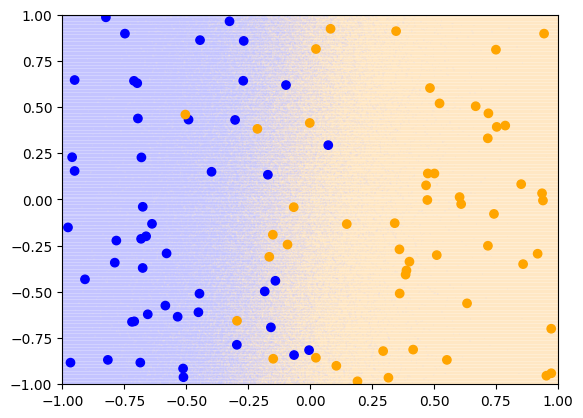

In [189]:
import matplotlib
BinaryBlOr = matplotlib.colors.ListedColormap(['blue', 'orange'])

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)

num_samples_per_dim = 1000
x1_samples = np.linspace(-1, 1, num_samples_per_dim)
x2_samples = np.linspace(-1, 1, num_samples_per_dim)
ground_truth_data = np.array(np.meshgrid(x1_samples, x2_samples))

grid_points = np.hstack((np.ones((num_samples_per_dim**2, 1)), np.reshape(ground_truth_data[0], (num_samples_per_dim**2, 1)), np.reshape(ground_truth_data[1], (num_samples_per_dim**2, 1))))
grid_values_ground_truth = np.reshape( label_generator(grid_points), (num_samples_per_dim,num_samples_per_dim) )

ax.pcolor(ground_truth_data[0], ground_truth_data[1], grid_values_ground_truth, cmap=BinaryBlOr, vmin=0, vmax=1, alpha=0.02)
ax.scatter(X[:,1], X[:,2], c=y, cmap=BinaryBlOr)



In [190]:
from sklearn.metrics import accuracy_score, f1_score
import time

def binary_cross_entropy(y_true, y_pred):
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    
    # Clip predictions to avoid log(0) and log(1)
    epsilon = 1e-15
    y_pred = np.clip(y_pred, epsilon, 1 - epsilon)

    loss = -np.mean(y_true * np.log(y_pred) + (1 - y_true) * np.log(1 - y_pred))

    return loss

In [191]:
def gradient_descent(X, y, weights=None, learning_rate=1e-4, max_iter=100000, eps=1e-8):
    y = np.array(y, dtype=int)
    if weights is None:
        weights = np.random.uniform(0, 1, X.shape[1])
    
    bce_prev = np.finfo(np.float16).max
    for i in range(max_iter):
        logits = sigmoid(X @ weights)
        gradient = -X.T @ (y-sigmoid(X @ weights))
        weights -= learning_rate*gradient
        y_hat = np.array(logits > 0.5, dtype=int)

        bce = binary_cross_entropy(y, logits)

        if abs(bce_prev - bce) <= eps:
            break
        bce_prev = bce
        
        acc = accuracy_score(y, y_hat)
        try:
            f1 = f1_score(y, y_hat)
        except:
            f1 = 0
        
        if i % 100 == 0:
            print(bce, acc, f1)

    print(i)

start = time.time()
gradient_descent(X, y)
end = time.time()

print(f'Elapsed time: {end-start}')

0.7722536821941145 0.53 0.6928104575163399
0.6870096609188329 0.53 0.6928104575163399
0.6224926219527187 0.53 0.6928104575163399
0.5726584523634481 0.73 0.7906976744186047
0.5331159903243755 0.83 0.8495575221238938
0.5009126353556003 0.86 0.8703703703703703
0.4741041355101985 0.89 0.897196261682243
0.4513923041027054 0.9 0.9056603773584906
0.4318827559363163 0.92 0.923076923076923
0.4149364631194047 0.9 0.9019607843137256
0.4000809317499355 0.9 0.9019607843137256
0.38695648462239723 0.91 0.910891089108911
0.37528280424433597 0.92 0.9215686274509803
0.36483728947935085 0.91 0.912621359223301
0.3554404942122344 0.91 0.912621359223301
0.34694596997306265 0.91 0.912621359223301
0.3392329569584227 0.91 0.912621359223301
0.332200987975634 0.91 0.912621359223301
0.3257658207700375 0.91 0.912621359223301
0.3198563193700208 0.91 0.912621359223301
0.31441202951684105 0.91 0.912621359223301
0.3093812715766388 0.91 0.912621359223301
0.30471962541193226 0.91 0.912621359223301
0.30038871607182105 0.

In [ ]:
# 1, x1, x2
# 1, x1, x2, x1*x2, x1*x1, x2*x2

